In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

In [3]:
# Read data into DataFrame
df= pd.read_csv('Online_Retail.csv')
df.head()

,TransactionNo,MerchandiseCode,Quan,TransactionDate,ItemPrice,UserID
0,29138841,85123A,8,2020-9-1,2.76,208163.0
1,29138841,71053,8,2020-9-1,2.12,208163.0
2,29138841,84406B,8,2020-9-1,5.12,208163.0
3,29138841,84029G,8,2020-9-1,4.33,208163.0
4,29138841,84029E,8,2020-9-1,3.39,208163.0


In [4]:
# Checking for null values

df.isna().sum().sort_values(ascending=False)

UserID             135080
TransactionNo           0
MerchandiseCode         0
Quan                    0
TransactionDate         0
ItemPrice               0
dtype: int64

In [5]:
df.dropna(axis=0, how='any', inplace=True)

In [6]:
df.isna().sum().sort_values(ascending=False)

TransactionNo      0
MerchandiseCode    0
Quan               0
TransactionDate    0
ItemPrice          0
UserID             0
dtype: int64

In [7]:
# Checking for data types
df.dtypes

TransactionNo       object
MerchandiseCode     object
Quan                 int64
TransactionDate     object
ItemPrice          float64
UserID             float64
dtype: object

In [8]:
df['TransactionDate']=pd.to_datetime(df['TransactionDate'])

In [9]:
df.describe()

,Quan,ItemPrice,UserID
count,406829.000000,406829.000000,4.068290e+05
mean,12.060453,3.460489,1.920313e+04
std,248.692568,69.315162,9.303983e+04
min,-80995.000000,0.000000,1.234600e+04
25%,2.000000,1.250000,1.396900e+04
50%,5.000000,1.950000,1.515900e+04
75%,12.000000,3.750000,1.680600e+04
max,80995.000000,38970.000000,3.661883e+06


In [10]:
# From the table above, we can see that the average price for items is 3.4, whereas stand deviation is 69.3. 
# The 50% position and 75% position are 1.95 and 3.75 resepectively, which means that most of items have similary prices. 
# However, the maxmimun ItemPrice is 38970.


In [11]:
# Pivot table

rfm = df.pivot_table(index='UserID',values=['ItemPrice','TransactionNo','TransactionDate'],aggfunc={'ItemPrice':'sum','TransactionNo':'count','TransactionDate':'max'})
rfm

,ItemPrice,TransactionDate,TransactionNo
UserID,,,
12346.0,2.08,2020-01-18,2
12347.0,481.21,2020-12-07,182
12348.0,178.71,2020-09-25,31
12349.0,605.10,2020-11-21,73
12350.0,65.30,2020-02-02,17
...,...,...,...
228661.0,791.28,2020-12-07,251
1725421.0,1122.66,2020-12-09,274
1725481.0,57.90,2020-10-12,28


In [15]:
rfm['R']=(rfm['TransactionDate'].max()-rfm['TransactionDate'])/np.timedelta64(1,'D')

rfm.rename(columns={'ItemPrice':'M','TransactionNo':'F'}, inplace=True)

rfm.describe()

,M,F,R
count,4372.000000,4372.000000,4372.000000
mean,322.009882,93.053294,81.538884
std,1284.784541,232.471608,84.630455
min,0.000000,1.000000,0.000000
25%,52.865000,17.000000,18.000000
50%,130.095000,42.000000,50.000000
75%,302.332500,102.000000,119.000000
max,41376.330000,7983.000000,340.000000


# Method 1-Scoring

In [ ]:
# There are three levels for each R,F,M
# For R, 0-50%=1, 50%-75%=2, 0%-25% =3
# For F, 0-50%=1, 50%-75%=2, 75%-100% =3
# For M, 0-50%=1, 50%-75%=2, 75%-100% =3

In [ ]:
# score 
rfm1=rfm

# R
def fun(x):
    if x>=50:return 1
    elif x>=18 and x<50:return 2
    else:return 3

rfm1['R']=rfm['R'].apply(lambda x: fun(x))


In [ ]:
# F
def fun(x):
    if x>42:return 1
    elif x>=42 and x<102:return 2
    else:return 3

rfm1['F']=rfm['F'].apply(lambda x: fun(x))

In [ ]:
# M
def fun(x):
    if x>130:return 1
    elif x>=130 and x<302:return 2
    else:return 3

rfm1['M']=rfm['M'].apply(lambda x: fun(x))

In [ ]:
rfm1

# Method 2: K-mean

In [16]:
# Data processing

rfm0 = rfm[['R','F','M']]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(rfm0)
rfm0 = scaler.transform(rfm0)
rfm0

array([[ 2.88890184, -0.3917197 , -0.24904291],
       [-0.9399451 ,  0.38265697,  0.12392609],
       [-0.07727279, -0.26695902, -0.11154888],
       ...,
       [-0.27816908, -0.27986529, -0.20559096],
       [-0.96357996,  0.80426204,  0.55418751],
       [-0.96357996, -0.17661507, -0.10483881]])

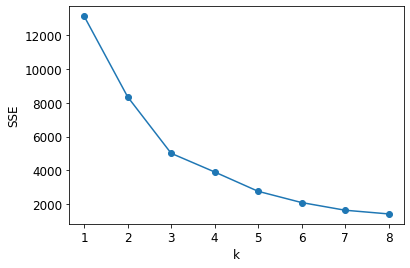

In [17]:
# Identify K
from sklearn.cluster import KMeans
SSE = []
for k in range(1,9):
    estimator = KMeans(n_clusters=k)
    estimator.fit(rfm0)
    SSE.append(estimator.inertia_)
X=range(1,9)
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(X,SSE,'o-')
plt.show()

In [18]:
# K=4


# KMean
kmodel = KMeans(n_clusters=4,random_state=33).fit(rfm0)


In [19]:
# Centroid for each cluster
centroid=kmodel.cluster_centers_
centroid

array([[-0.49594742, 14.45049977, 21.69935274],
       [-0.38410613, -0.1146577 , -0.09147048],
       [ 1.76737292, -0.2917204 , -0.17231213],
       [-0.77841539,  1.61367973,  0.90284918]])

In [20]:
# The category corresponding to each sample
cluster_labels=kmodel.labels_
cluster_labels

array([2, 1, 1, ..., 1, 3, 1])

In [21]:
rfm2=rfm
rfm2['Category']=cluster_labels
rfm2

,M,TransactionDate,F,R,Category
UserID,,,,,
12346.0,2.08,2020-01-18,2,326.0,2
12347.0,481.21,2020-12-07,182,2.0,1
12348.0,178.71,2020-09-25,31,75.0,1
12349.0,605.10,2020-11-21,73,18.0,1
12350.0,65.30,2020-02-02,17,311.0,2
...,...,...,...,...,...
228661.0,791.28,2020-12-07,251,2.0,1
1725421.0,1122.66,2020-12-09,274,0.0,3
1725481.0,57.90,2020-10-12,28,58.0,1


In [22]:
# Number of people for each category
rfm2['Category'].value_counts()

1    3213
2     839
3     313
0       7
Name: Category, dtype: int64

## Visualization and Interpretation



In [23]:
# Centroid and Size
r1=pd.Series(cluster_labels).value_counts()
r2=pd.DataFrame(centroid)
r=pd.concat([r2,r1],axis=1)
r.columns = list(rfm.loc[:,['R','F','M']]) + ['Size']
r

,R,F,M,Size
0,-0.495947,14.450500,21.699353,7
1,-0.384106,-0.114658,-0.091470,3213
2,1.767373,-0.291720,-0.172312,839
3,-0.778415,1.613680,0.902849,313


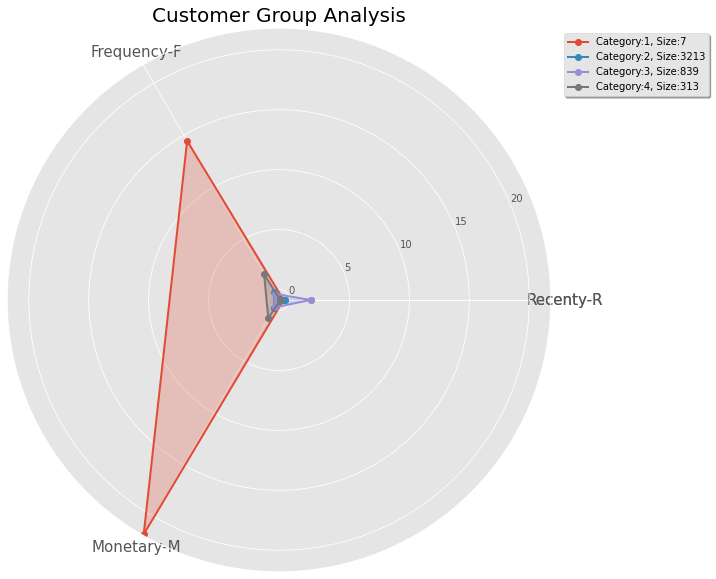

In [51]:
plt.rcParams['font.size'] = 12.0
plt.rcParams['axes.unicode_minus'] = False

max = r2.values.max()
min = r2.values.min()

plt.style.use('ggplot')
fig =plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, polar=True)

center_num = r.values
feature = ['Recenty-R','Frequency-F', 'Monetary-M']


N=len(feature)

for i,v in enumerate(center_num):
    angles = np.linspace(0, 2*np.pi, N, endpoint=False)
    center = np.concatenate((v[:-1], [v[0]]))
    angles = np.concatenate((angles,[angles[0]]))
    labels = np.concatenate((feature,[feature[0]]))
    ax.plot(angles, center, 'o-', linewidth=2,label="Category:%d, Size:%d"%(i+1,v[-1]))
    ax.fill(angles,center,alpha=0.25)
    ax.set_thetagrids(angles * 180/np.pi,labels,fontsize=15)
    ax.set_ylim(min - 0.1, max + 0.1)
plt.title('Customer Group Analysis',fontsize=20)

ax.grid(True)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), ncol=1, fancybox=True, shadow=True)
plt.show()